In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import random, math

In [21]:
class CuttingStock:
    def __init__(self, rects, radius, pop_size=100):
        self.rects = rects  # list (w, h, v) for each rectangle
        self.radius = radius
        self.pop_size = pop_size
        self.generation = self._init_population()
        self.best_individual = None
        self.best_fitness = 0
        self.fit_history = []

    def _init_population(self):
        population = []
        for _ in range(self.pop_size):
            individual = self._fit_rects()
            population.append(individual)
        return population
    
    def _fit_rects(self, rect_ids=None):
        x = -self.radius
        y = self.radius
        individual = [] if rect_ids is None else list(rect_ids) # storing rect_ids
        rect_grid = [] # storing rects with positions [id, x_center, y_center]
        i = 0

        while x < self.radius:
            if rect_ids is not None and i < len(rect_ids):
                rect_id = rect_ids[i]
                i += 1
            else:
                rect_id = random.randint(0, len(self.rects) - 1)
            w, h, v = self.rects[rect_id]
            if x + w > self.radius:
                break
            if rect_ids is None:
                individual.append(rect_id)

            y = self.radius
            while y > -self.radius:
                if y - h < -self.radius:
                    break
                x_center = x + w / 2
                y_center = y - h / 2 
                rect_grid.append([rect_id, x_center, y_center])
                y -= h

            x += w

        return individual, rect_grid
    
    def _fitness(self, individual):
        _, rect_grid = individual
        total_value = 0
        for rect_id, x_c, y_c in rect_grid:
            w, h, v = self.rects[rect_id]
            corners = [
                (x_c - w / 2, y_c - h / 2),
                (x_c - w / 2, y_c + h / 2),
                (x_c + w / 2, y_c - h / 2),
                (x_c + w / 2, y_c + h / 2)
            ]
            fits = all(math.hypot(x, y) <= self.radius for x, y in corners)
            if fits:
                total_value += v
        return total_value
    
    def tournament_selection(self, k=3):
        candidates = random.sample(self.generation, k)
        best_candidate = max(candidates, key=self._fitness)
        return best_candidate
    
    def run(self, generations=10, mutation_rate=0.1, k=3, verbose=True):
        best_fit = max(self.generation, key=self._fitness)
        best_fit_value = self._fitness(best_fit)
        self.fit_history.append(best_fit_value)
        for gen in range(generations):
            if verbose:
                print(f"Generation {gen}: Best fitness = {best_fit_value}")
            new_generation = []
            for _ in range(self.pop_size):
                parent1 = self.tournament_selection(k)[0]
                parent2 = self.tournament_selection(k)[0]
                child_ids = []
                for i in range(min(len(parent1), len(parent2))):
                    chosen = random.choice([parent1[i], parent2[i]])
                    child_ids.append(chosen)
                
                if random.random() < mutation_rate and child_ids:
                    mutation_index = random.randint(0, len(child_ids) - 1)
                    mutation_value = random.randint(0, len(self.rects) - 1)
                    child_ids[mutation_index] = mutation_value
                
                child = self._fit_rects(child_ids)
                new_generation.append(child)

            self.generation = new_generation
            best_fit = max(self.generation, key=self._fitness)
            best_fit_value = self._fitness(best_fit)
            self.fit_history.append(best_fit_value)
            if verbose:
                print(f"Generation {gen + 1}: Best fitness = {best_fit_value}")

            if best_fit_value > self.best_fitness:
                self.best_fitness = best_fit_value
                self.best_individual = best_fit
        
        print(f"Best individual: {self.best_individual[0]}")
        print(f"Best fitness: {self.best_fitness}")

    
    def visualize_individual(self, individual_data):
        individual, rect_grid = individual_data

        fig, ax = plt.subplots(figsize=(8, 8))

        # Draw the circle
        circle = plt.Circle((0, 0), self.radius, fill=False, edgecolor='blue', linewidth=2)
        ax.add_artist(circle)

        green_value = 0 

        rects_coords = [] 

        for idx, (rect_id, x_c, y_c) in enumerate(rect_grid):
            w, h, v = self.rects[rect_id]
            left = x_c - w / 2
            right = x_c + w / 2
            bottom = y_c - h / 2
            top = y_c + h / 2

            corners = [
                (left, bottom),
                (left, top),
                (right, bottom),
                (right, top)
            ]
            fits_circle = all(math.hypot(x, y) <= self.radius for x, y in corners)

            overlaps = False
            for (l2, r2, b2, t2) in rects_coords:
                if not (right <= l2 or left >= r2 or top <= b2 or bottom >= t2):
                    overlaps = True
                    break

            fits = fits_circle and not overlaps
            color = 'green' if fits else 'red'
            if fits:
                green_value += v
                rects_coords.append((left, right, bottom, top))

            rect_patch = patches.Rectangle(
                (left, bottom), w, h,
                linewidth=1, edgecolor='black', facecolor=color, alpha=0.6
            )
            ax.add_patch(rect_patch)

            ax.text(x_c, y_c, str(v), ha='center', va='center', fontsize=8, color='black')

        ax.set_xlim(-self.radius - 50, self.radius + 50)
        ax.set_ylim(-self.radius - 50, self.radius + 50)
        ax.set_aspect('equal')
        ax.set_title(f"Total value of fitting rectangles: {green_value}")
        plt.grid(True)
        plt.show()


    def plot_fitness_history(self):
        plt.plot(self.fit_history)
        plt.title('Fitness history')
        plt.xlabel('Generation')
        plt.ylabel('Fitness value')
        plt.grid()
        plt.show()

## Radius 800 circle (acceptance threshold: 30000)

In [17]:
r800 = pd.read_csv('dane_ae/cutting/cutting/r800.csv')
rectangles = r800.values.tolist()
rectangles

[[320, 160, 500], [250, 160, 600], [150, 120, 40], [400, 30, 400]]

Best individual: [2, 3, 3, 3]
Best fitness: 47000


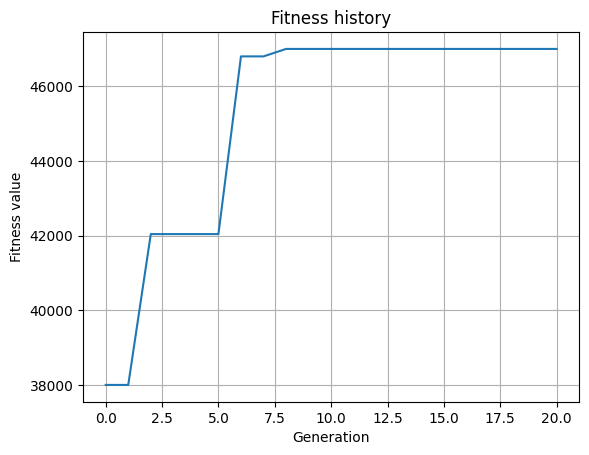

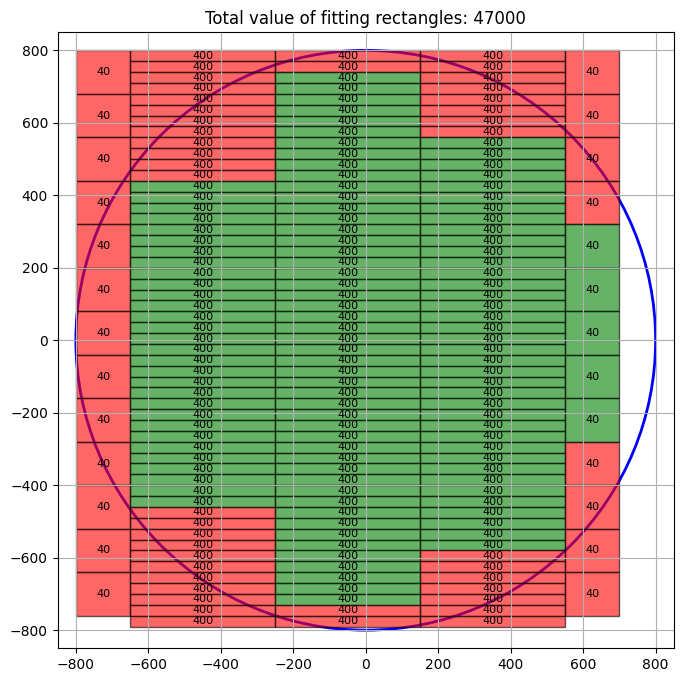

In [81]:
radius = 800 
cs = CuttingStock(rectangles, radius, pop_size=20)
cs.run(generations=20, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

## Radius 1200 circle (acceptance threshold: 30000)

In [82]:
r1200 = pd.read_csv('dane_ae/cutting/cutting/r1200.csv')
rectangles = r1200.values.tolist()
rectangles

[[200, 160, 300], [250, 160, 500], [100, 120, 40]]

Best individual: [2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Best fitness: 44740


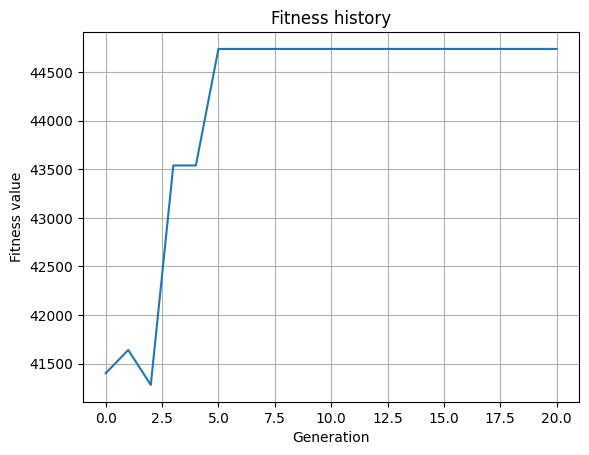

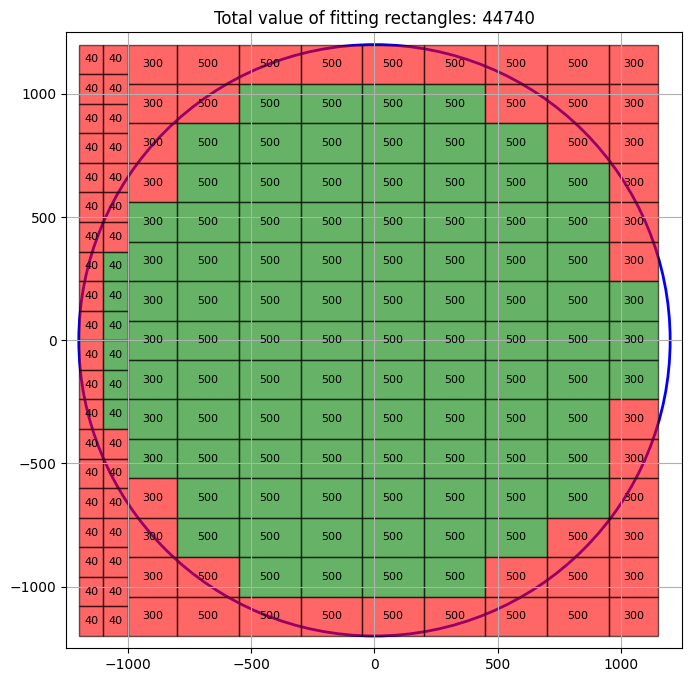

In [83]:
radius = 1200
cs = CuttingStock(rectangles, radius, pop_size=20)
cs.run(generations=20, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

## Radius 1000 circle (acceptance threshold: 17500)

In [84]:
r1000 = pd.read_csv('dane_ae/cutting/cutting/r1000.csv')
rectangles = r1000.values.tolist()
rectangles

[[200, 160, 300], [250, 160, 500], [100, 120, 40]]

Best individual: [2, 1, 1, 1, 1, 1, 1, 1, 2]
Best fitness: 29660


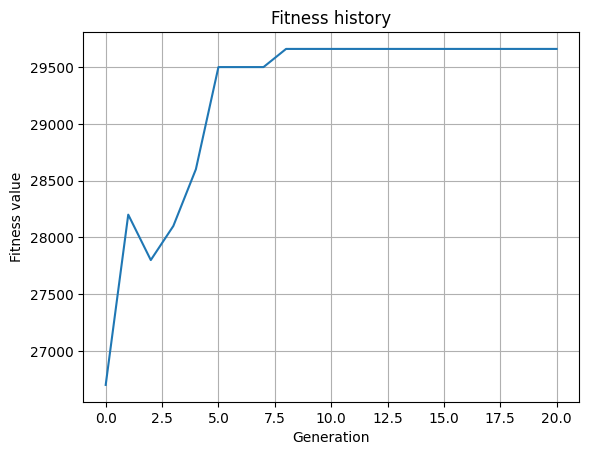

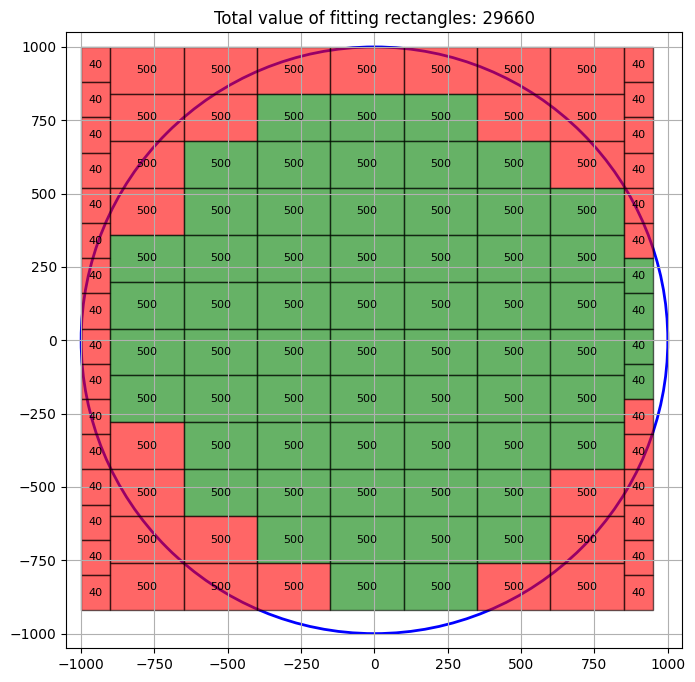

In [98]:
radius = 1000
cs = CuttingStock(rectangles, radius, pop_size=20)
cs.run(generations=20, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

## Radius 1100 circle (acceptance threshold: 25000)

In [8]:
r1100 = pd.read_csv('dane_ae/cutting/cutting/r1100.csv')
rectangles = r1100.values.tolist()
rectangles

[[120, 360, 300], [250, 160, 600], [150, 120, 40]]

Best individual: [2, 2, 1, 1, 1, 1, 1, 1, 1, 0]
Best fitness: 36640


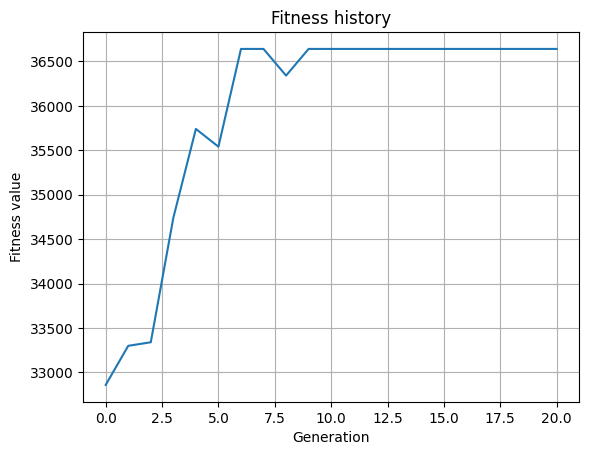

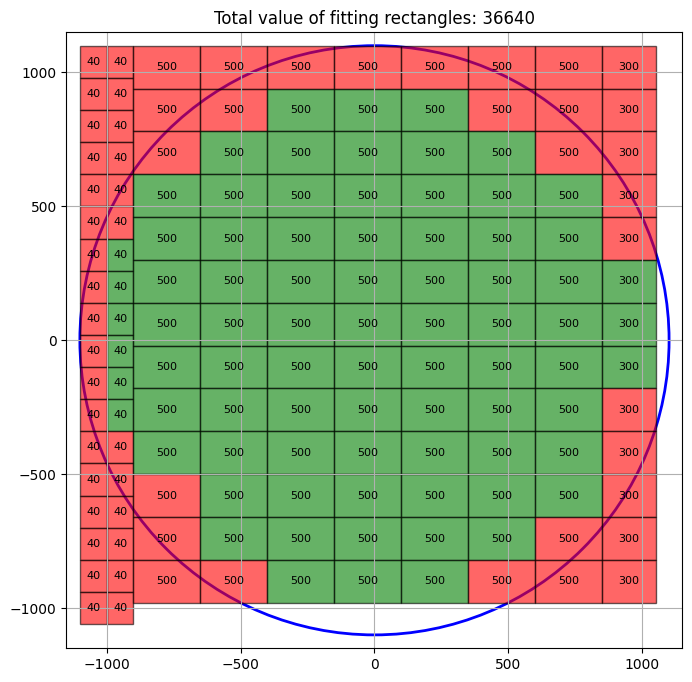

In [101]:
radius = 1100
cs = CuttingStock(rectangles, radius, pop_size=20)
cs.run(generations=20, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

## Radius 850 circle

In [102]:
r850 = pd.read_csv('dane_ae/cutting/cutting/r850.csv')
rectangles = r850.values.tolist()
rectangles

[[120, 10, 150],
 [400, 20, 1200],
 [300, 30, 1200],
 [120, 120, 1200],
 [100, 100, 900],
 [450, 80, 11000]]

Best individual: [4, 0, 5, 5, 5]
Best fitness: 488900


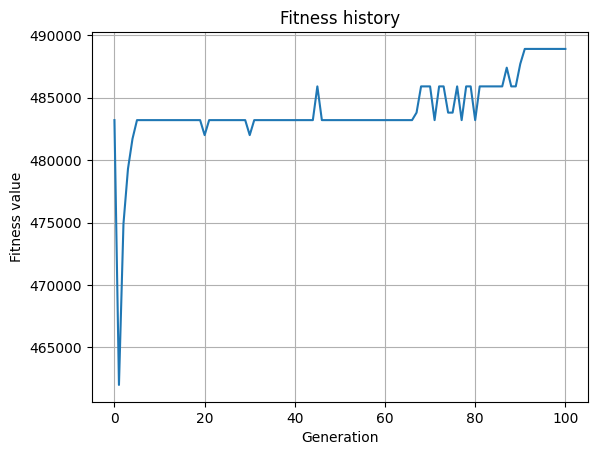

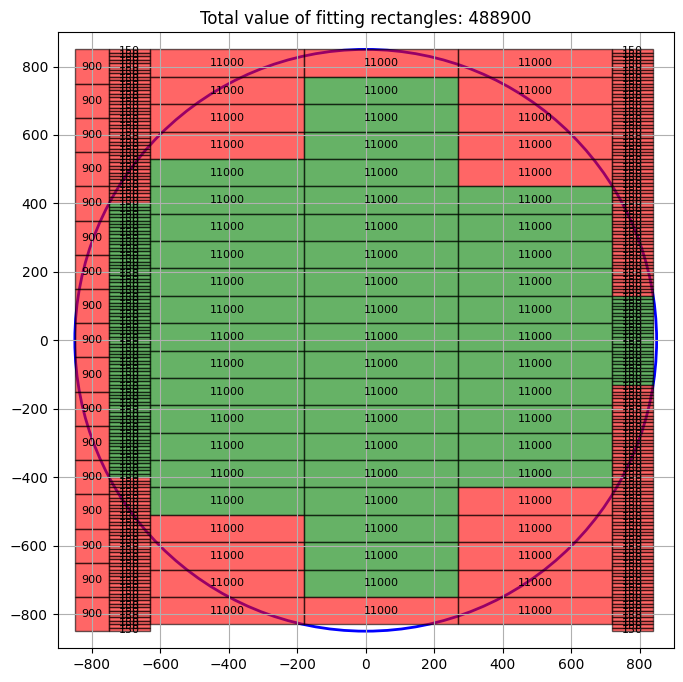

In [107]:
radius = 850 
cs = CuttingStock(rectangles, radius, pop_size=20)
cs.run(generations=100, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

## to samo z wieksza populacja ale mala liczba generacji

Best individual: [4, 0, 5, 5, 5]
Best fitness: 488900


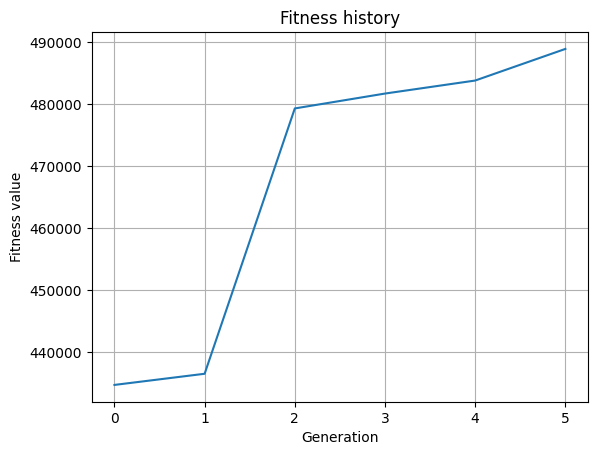

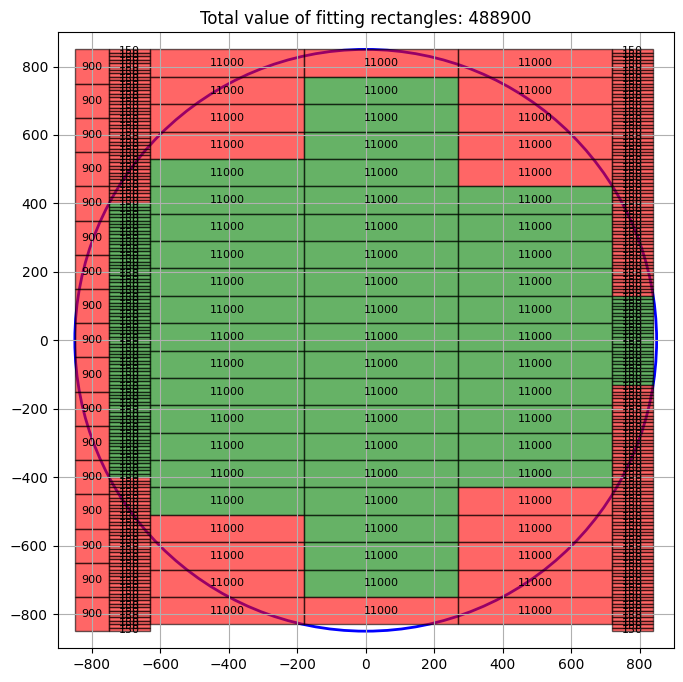

In [112]:
radius = 850 
cs = CuttingStock(rectangles, radius, pop_size=50)
cs.run(generations=5, mutation_rate=0.1, k=3, verbose=False)
cs.plot_fitness_history()
cs.visualize_individual(cs.best_individual)

### wydaje sie być to zmaksymalizowany wynik dla takiej implementacji 